In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import sys
import gzip
from scipy import stats
import scipy as sp
import community

from network_ei import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

# Causal Structure as a Network: Quantifying Certainty in Complex Systems

# Chapter 09: Determinism and Degeneracy

Determinism and degeneracy are two properties that exist in every causal structure, and they govern the degree of certainty about the relationships between causes and effects in a system based on the network connectivity. A visual explanation of these two quantities are shown this notebook. Determinism and degeneracy can be arrived at by decomposing the KL Divergence that defines $EI$, but since they are fundamental to the notion of causality, they can also be built up from first principles, as we do here.

Previously we defined an intervention as introducing random walkers on a node in the network, $do_{net}(v_i)$. The amount of uncertainty in the paths of those random walkers is how much information is lost from noise if the random walker is placed on a $v_i$. This is in turn a function of the strength of the output of a node, i.e., the certainty of transitions or dependencies (the determinism of those transition profiles). Therefore we define the determinism using the average entropy of $W^{out}_{i}$ and the degeneracy with the entropy of $W^{in}$ such that:

\begin{align}
    \text{determinism} &= \text{log}_2(N) - \dfrac{1}{N_{out}}\displaystyle \sum_i^{N_{out}} H[W^{out}_{i}] \tag{4}\\\
    \text{degeneracy} &= \text{log}_2(N) - H[W^{in}] \tag{5}
\end{align}

_______________________________

In a maximally deterministic system wherein all nodes have a single output and every entry in $W^{out}_{i}=1.00$, the determinism is just $\text{log}_2(N)$ because their $H[W^{out}_{i}]=0.00$. Conversely, the degeneracy is the amount of information lost via an overlap in input weights (e.g. if multiple nodes output to the same node). The degeneracy is $\text{log}_2(N) - H[W^{in}]$. In a perfectly non-degenerate system wherein all nodes have an equal input weight, the degeneracy is zero because $H[W^{in}] \approx H_{max}$.

These two quantities provide clear explanations for why canonical networks have the $EI$ they do. For example, as the size of an Erdös-Rényi random network increases, its value for degeneracy approaches zero, which means the the $EI$ of a random network is driven only by the determinism of the network. Similarly, in $d$-dimensional ring lattice networks, the degeneracy term is always zero. Therefore, the \textit{EI} of a ring lattice structure reduces to the determinism of that structure. Ring networks with an average degree $\langle k \rangle$ will have a higher $EI$ than ER networks with the same average degree because ring networks will have a higher determinism value. Interestingly, in the case of star networks, the degeneracy term governs the decay of the $EI$ such that hub-and-spoke-like structures quickly become uninformative in terms of cause and effect.

### 3-node Directed Motifs
<img src="figs/pngs/13Motifs.png">

Figure 3: **Effective Information of 3-node network motifs.** The space of all directed 3-node subgraphs and their associated $EI$. Real networks can be characterized by how prevalent each of these motifs are in the global network structure.

In [13]:
def plot_four_TPMS(tpm0, tpm1, tpm2, tpm3, labels=[], save=False):
    """A cute lil plotting function for plotting four TPMs."""
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(17,4))
    ax0.imshow(tpm0, cmap="GnBu")
    ax1.imshow(tpm1, cmap="Oranges")
    ax2.imshow(tpm2, cmap="YlGn")
    ax3.imshow(tpm3, cmap="RdPu")

    if labels:
        ax0.set_title(labels[0], size=17, fontweight="heavy")
        ax1.set_title(labels[1], size=17, fontweight="heavy")
        ax2.set_title(labels[2], size=17, fontweight="heavy")
        ax3.set_title(labels[3], size=17, fontweight="heavy")

    else:
        ax0.set_title("Copy-Copy\n", size=15)
        ax1.set_title("And-And\n", size=15)
        ax2.set_title("Or-Or\n", size=15)
        ax3.set_title("Star\n", size=15)
    
    ax0.set_xticks(np.arange(0, 3, 1));
    ax0.set_yticks(np.arange(0, 3, 1));
    ax0.set_xticklabels(np.arange(0, 3, 1));
    ax0.set_yticklabels(np.arange(0, 3, 1));
    ax0.set_xticks(np.arange(-.5, 2.5, 1), minor=True);
    ax0.set_yticks(np.arange(-.5, 2.5, 1), minor=True);
    ax0.grid(which='minor', color='darkgrey', linestyle='-', linewidth=3)
    ax0.xaxis.tick_top()

    ax1.set_xticks(np.arange(0, 3, 1));
    ax1.set_yticks(np.arange(0, 3, 1));
    ax1.set_xticklabels(np.arange(0, 3, 1));
    ax1.set_yticklabels(np.arange(0, 3, 1));
    ax1.set_xticks(np.arange(-.5, 2.5, 1), minor=True);
    ax1.set_yticks(np.arange(-.5, 2.5, 1), minor=True);
    ax1.grid(which='minor', color='darkgrey', linestyle='-', linewidth=3)
    ax1.xaxis.tick_top()

    ax2.set_xticks(np.arange(0, 3, 1));
    ax2.set_yticks(np.arange(0, 3, 1));
    ax2.set_xticklabels(np.arange(0, 3, 1));
    ax2.set_yticklabels(np.arange(0, 3, 1));
    ax2.set_xticks(np.arange(-.5, 2.5, 1), minor=True);
    ax2.set_yticks(np.arange(-.5, 2.5, 1), minor=True);
    ax2.grid(which='minor', color='darkgrey', linestyle='-', linewidth=3)
    ax2.xaxis.tick_top()

    ax3.set_xticks(np.arange(0, 3, 1));
    ax3.set_yticks(np.arange(0, 3, 1));
    ax3.set_xticklabels(np.arange(0, 3, 1));
    ax3.set_yticklabels(np.arange(0, 3, 1));
    ax3.set_xticks(np.arange(-.5, 2.5, 1), minor=True);
    ax3.set_yticks(np.arange(-.5, 2.5, 1), minor=True);
    ax3.grid(which='minor', color='darkgrey', linestyle='-', linewidth=3)
    ax3.xaxis.tick_top()

    if save:
        plt.savefig("figs/FourSampleTPMS.png", dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
motif_dict = getMotifs()
for motif in motif_dict.keys():
    motif_dict[motif]['EI'] = get_ei(motif_dict[motif]['G'])
    print(motif, "=", motif_dict[motif]['edges'])

Motif 01 = [(0, 1), (0, 2)]
Motif 02 = [(0, 1), (2, 0)]
Motif 03 = [(0, 1), (0, 2), (2, 0)]
Motif 04 = [(1, 0), (2, 0)]
Motif 05 = [(0, 2), (1, 0), (1, 2)]
Motif 06 = [(0, 2), (0, 1), (1, 0), (1, 2)]
Motif 07 = [(0, 2), (1, 0), (2, 0)]
Motif 08 = [(0, 1), (0, 2), (1, 0), (2, 0)]
Motif 09 = [(0, 2), (1, 0), (2, 1)]
Motif 10 = [(0, 1), (1, 0), (1, 2), (2, 0)]
Motif 11 = [(0, 1), (1, 0), (2, 0), (2, 1)]
Motif 12 = [(0, 1), (0, 2), (1, 0), (1, 2), (2, 1)]
Motif 13 = [(0, 1), (0, 2), (1, 0), (1, 2), (2, 1), (2, 0)]


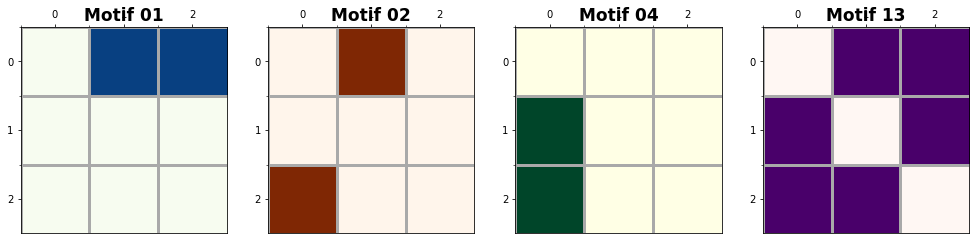

In [27]:
labs = sorted(list(np.random.choice(list(motif_dict.keys()), 
                                    size=4, replace=False)))
four_examples = [nx.to_numpy_array(motif_dict[labs[0]]['G']), 
                 nx.to_numpy_array(motif_dict[labs[1]]['G']), 
                 nx.to_numpy_array(motif_dict[labs[2]]['G']), 
                 nx.to_numpy_array(motif_dict[labs[3]]['G'])]
plot_four_TPMS(four_examples[0], four_examples[1], 
               four_examples[2], four_examples[3],labs)

In [30]:
ei_heights = np.array([list(motif_dict.values())[i]['EI'] 
                       for i in range(len(list(motif_dict.values())))]) + 0.005
ei_bars = np.array(range(len(list(motif_dict.values()))))
colors = ["#486164","#9094c9","#ab4e53","#fa8d11","#74d76c",
          "#bc7dc6","#db453b","#cad24b","#8f52d2","#00aaff",
          "#c2843a","#4f5435","#d05185"]

bar_labels = list(motif_dict.keys())

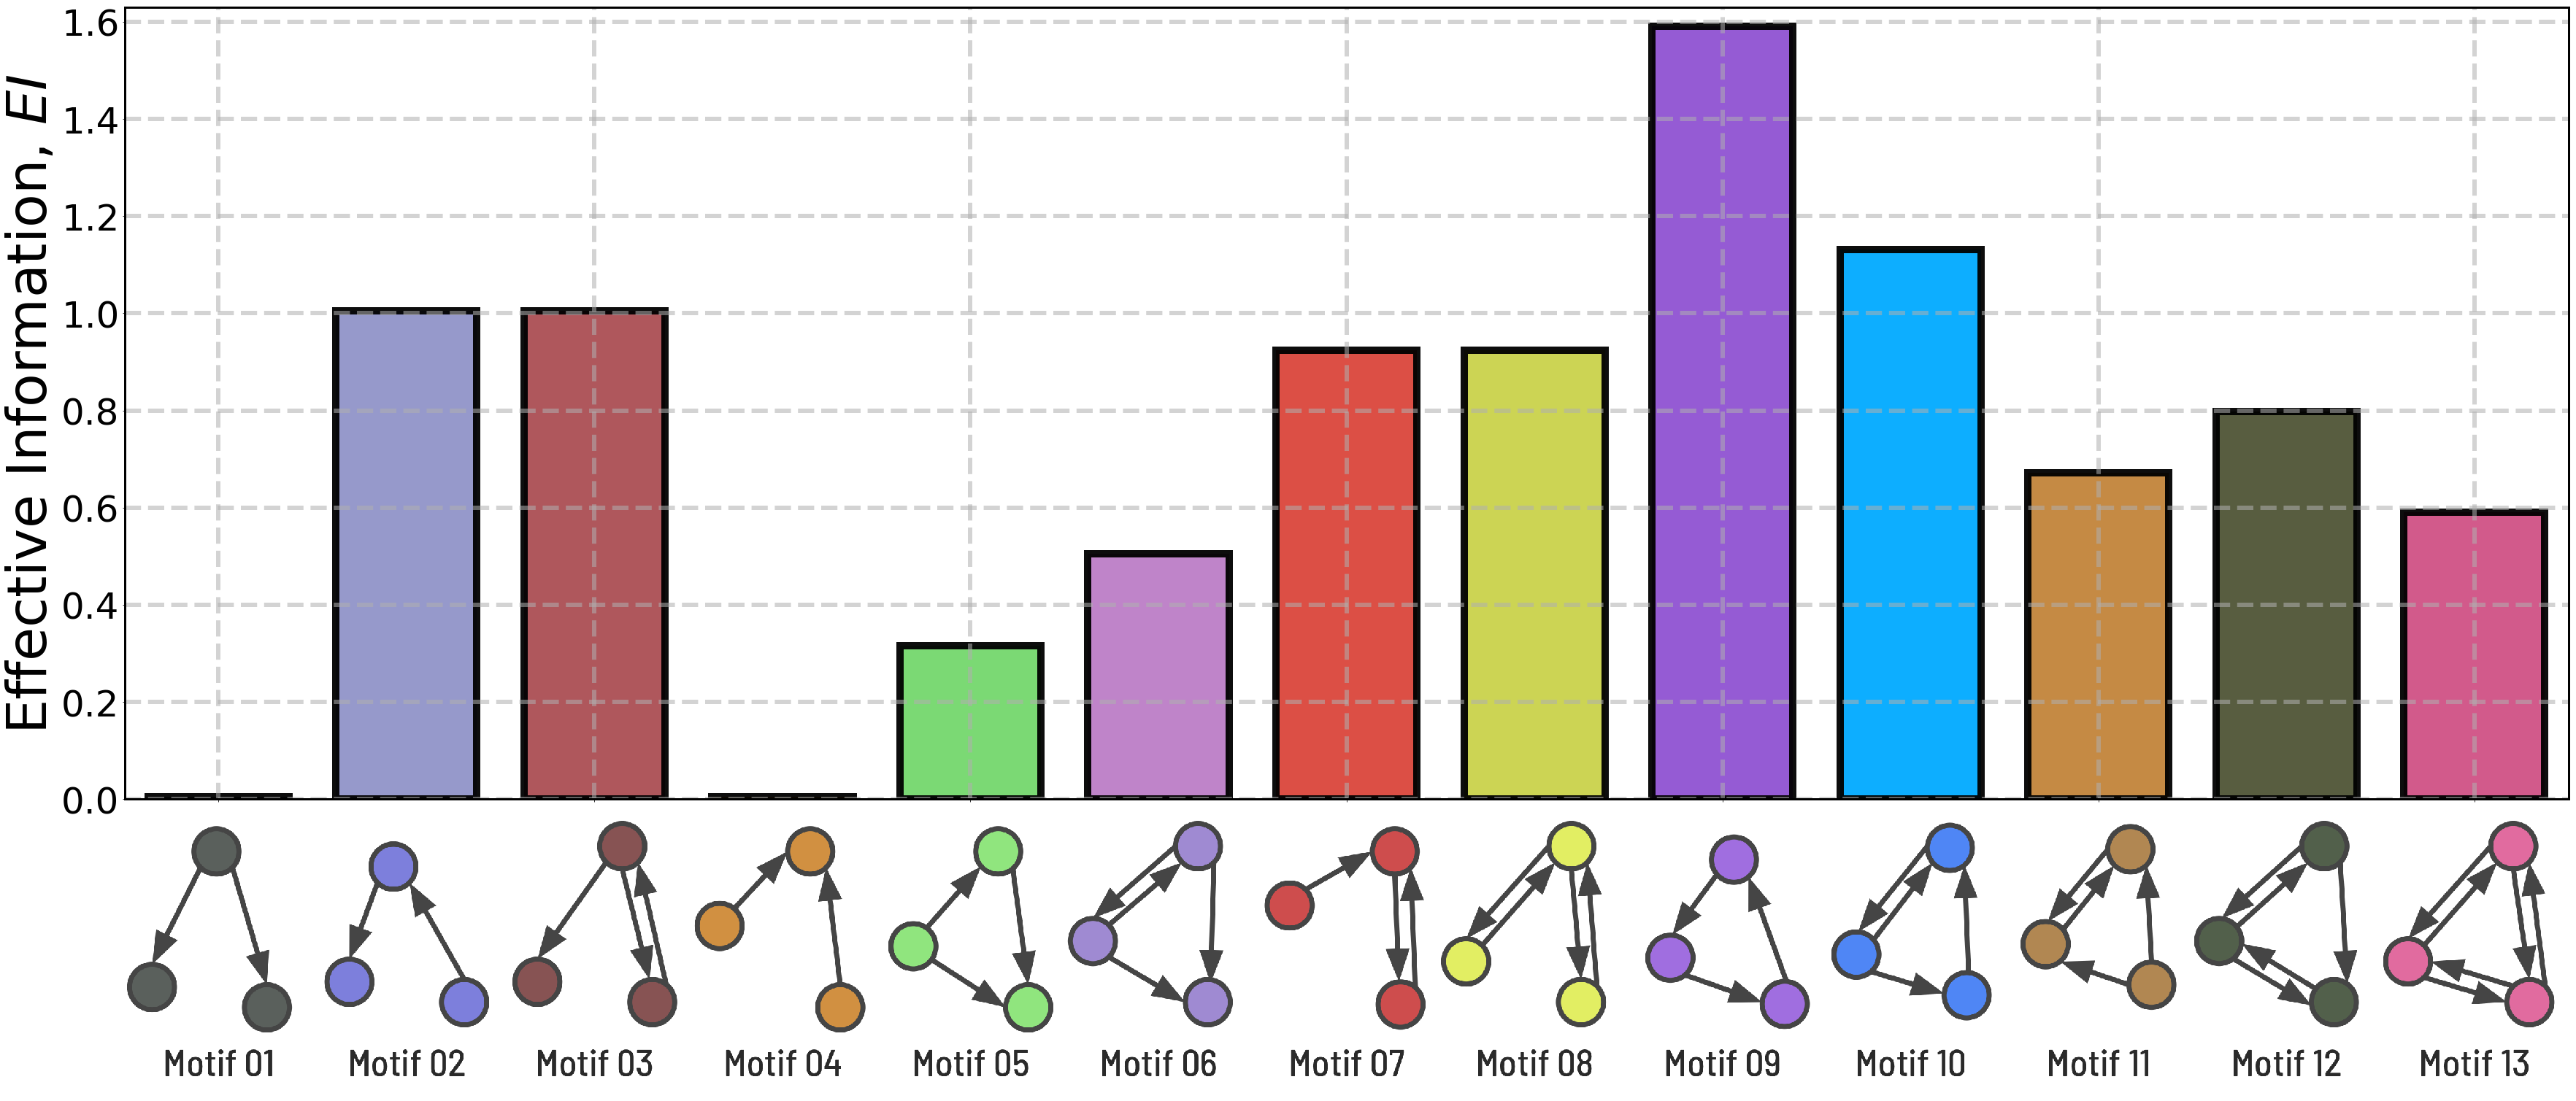

In [31]:
plt.rc('axes', linewidth=3)
# plt.rc('axes', set_alpha=0.4)

plt.figure(figsize=(60,30))
ax0 = plt.subplot2grid((60,60), (0, 0), colspan=60, rowspan=40)
ax1 = plt.subplot2grid((60,60), (40, 0), colspan=61, rowspan=15)
arr_hand = read_png('figs/13Motifs.png')
imagebox = OffsetImage(arr_hand, zoom=1.0)

ax0.bar(ei_bars, ei_heights, color=colors, width=0.75, edgecolor='k', 
        linewidth=10.0, alpha=0.95)
img = ax1.imshow(arr_hand)
ax1.axis('off')
ax0.set_ylabel("Effective Information, $EI$", size=75)
ax0.set_yticklabels(np.round(np.linspace(0,1.6,num=9),2), size=50)
ax0.set_xticklabels([" "]*13)
ax0.set_ylim(0, max(ei_heights)+0.04)
ax0.set_xlim(-0.5,12.5)
ax0.grid(True, linestyle='--', linewidth=6.0, alpha=0.55)

# plt.savefig("figs/EffectiveInfo_NetworkMotifs.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/EffectiveInfo_NetworkMotifs.png", dpi=425, bbox_inches='tight')
plt.show()

## End of Chapter 03. In Chapter 04, we will look at *causal emergence* in networks
_______________